In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageOps
from lxml import etree
import matplotlib.pyplot as plt
import requests
import cv2
"""
os.add_dll_directory(
    r"C:\Program Files\OpenSlide\openslide-bin-4.0.0.8-windows-x64\bin"
)"""
from openslide import OpenSlide, OpenSlideError

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    DEBUG = '\033[96m'
    INFO = '\033[92m'
    WARNING = '\033[93m'
    ERROR = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

print(f"Workig directory: {os.getcwd()}")

def show_overlay(wsi_path, mask_path, level=4, alpha=0.4): # Shows overlay for level 4a
    slide = OpenSlide(wsi_path)
    dims = slide.level_dimensions[level]
    wsi_img = slide.read_region((0, 0), level, dims).convert("RGB")

    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(wsi_img.size) 
    wsi_np = np.array(wsi_img)
    mask_np = np.array(mask)

    # Create red mask overlay
    red_overlay = np.zeros_like(wsi_np)
    red_overlay[..., 0] = 255  # red channel

    # Blend the red mask where mask is present
    blended = np.where(mask_np[..., None] > 0,
                       (1 - alpha) * wsi_np + alpha * red_overlay,
                       wsi_np).astype(np.uint8)

    # Show the result
    plt.figure(figsize=(10, 10))
    plt.imshow(blended)
    plt.axis("off")
    plt.title("Tumor Slide with Mask Overlay")
    plt.show()

tumor_path = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img", "tumor_076.tif")

def visualize_mask_and_thumbnail(slide_id="tumor_001", level=6):
    wsi_dir = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img")
    annot_dir = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "mask", "annotations") 

    wsi_filename = f"{slide_id}.tif"
    xml_filename = f"{slide_id}.xml"

    wsi_path = os.path.join(wsi_dir, wsi_filename)
    xml_path = os.path.join(annot_dir, xml_filename)

    if not os.path.exists(wsi_path):
        print(f"Error: WSI not found at {wsi_path}")
        return
    if not os.path.exists(xml_path):
        print(f"Error: XML annotation not found at {xml_path}. This slide might be a normal one or the path is incorrect.")
        return

    try:
        slide = OpenSlide(wsi_path)
    except OpenSlideError as e:
        print(f"Error opening WSI {wsi_path}: {e}")
        return

    if level >= slide.level_count:
        print(f"Error: Level {level} is too high for this slide. Max level is {slide.level_count - 1}.")
        slide.close()
        return

    level_dims = slide.level_dimensions[level]
    downsample = slide.level_downsamples[level]

    print(f"Processing slide: {slide_id}")
    print(f"WSI path: {wsi_path}")
    print(f"XML path: {xml_path}")
    print(f"Thumbnail Level: {level}, Dimensions: {level_dims}, Downsample: {downsample}")

    thumbnail = slide.read_region((0, 0), level, level_dims).convert("RGB")
    print(f"Thumbnail size: {thumbnail.size}")

    mask = parse_xml_mask(xml_path, level_dims, slide)
    if mask is None:
        print("Mask generation failed. Exiting visualization.")
        slide.close()
        return

    print(f"Mask size: {mask.size}")

    # Convert mask to a colored overlay for better visualization
    mask_np = np.array(mask)
    colored_mask = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
    colored_mask[mask_np == 255] = [255, 0, 0] # Red color for tumor regions (since fill=255)

    thumbnail_np = np.array(thumbnail)

    # Use cv2.addWeighted for blending if available, otherwise numpy fallback
    if 'cv2' in globals() and hasattr(cv2, 'addWeighted'):
        overlay = Image.fromarray(cv2.addWeighted(thumbnail_np, 0.6, colored_mask, 0.4, 0)) # Thumbnail 60%, Red Mask 40%
    else:
        # Fallback blending (simple average, less visually appealing than addWeighted but works)
        alpha = 0.4
        overlay_np = (thumbnail_np * (1 - alpha) + colored_mask * alpha).astype(np.uint8)
        overlay = Image.fromarray(overlay_np)


    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    axes[0].imshow(thumbnail)
    axes[0].set_title(f'Original Thumbnail (Level {level})')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Generated Binary Mask')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (Tumor in Red)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    slide.close()
    print("Visualization complete.")


def parse_xml_mask(xml_path, level_dims, slide):
    """
    Convert XML annotation to binary mask.
    Parameters:
    - xml_path: str, path to the XML file containing annotations.
    - level_dims: tuple, dimensions of the WSI at the specified level (width, height).
    - slide: OpenSlide object for the WSI.
    - level: int, target level for mask.
    """
    try:
        tree = etree.parse(xml_path)
    except etree.XMLSyntaxError as e:
        print(f"{bcolors.ERROR}[ERROR]{bcolors.ENDC} Error parsing XML file {xml_path}: {e}")
        return None

    # Compute scaling factors based on actual dimensions
    base_dims = slide.level_dimensions[0]
    scale_x = level_dims[0] / base_dims[0]
    scale_y = level_dims[1] / base_dims[1]

    mask = Image.new("L", level_dims, 0)
    draw = ImageDraw.Draw(mask)

    for coordinates_node in tree.xpath("//Annotation/Coordinates | //Annotations/Annotation/Coordinates"):
        coords = []
        for coord_node in coordinates_node.findall("Coordinate"):
            try:
                x = float(coord_node.get("X"))
                y = float(coord_node.get("Y"))
                # Scale coordinates to the target level
                scaled_x = int(x * scale_x)
                scaled_y = int(y * scale_y)
                coords.append((scaled_x, scaled_y))
            except (ValueError, TypeError) as e:
                print(f"{bcolors.WARNING}Warning: Could not parse coordinate (X,Y) from XML for {xml_path}: {e}{bcolors.ENDC}")
                continue
        if coords:
            draw.polygon(coords, outline=255, fill=255)
    return mask


def extract_patches(patch_size=224, level=3, stride=None, pad=True):
    print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} Extracting patches at level {level}...")
    stride = stride or patch_size

    # Set patch size according to level
    patch_sizes = {0: 1792, 1: 896, 2: 448, 3: 224}
    patch_size = patch_sizes.get(level, 224)

    wsi_dir = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img", "tumor_076.tif")
    annot_dir_train = os.path.join(
        os.getcwd(), "..",  "data", "camelyon16", "train", "mask", "annotations"
    )
    annot_dir_test = os.path.join(
        os.getcwd(), "..", "data", "camelyon16", "test", "mask", "annotations"
    )
    level_dir = os.path.join(
        os.getcwd(), "..", "data", "camelyon16", "patches", f"level_{level}"
    )
    os.makedirs(level_dir, exist_ok=True)

    prefix = "tumor_076"

    # Check if patches for this image already exist
    patch_save_dir = os.path.join(level_dir, prefix)
    if (
        os.path.exists(patch_save_dir)
        and len(os.listdir(patch_save_dir)) > 0
        and any(f.endswith("_normal.png") for f in os.listdir(patch_save_dir))
        and any(f.endswith("_tumor.png") for f in os.listdir(patch_save_dir))
    ):
        print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} Patches for {prefix} already extracted, skipping.")
        return
        
    os.makedirs(patch_save_dir, exist_ok=True)

    xml_name = "tumor_076.xml"
    xml_path = os.path.join(annot_dir_train, xml_name)
    try:
        slide = OpenSlide(wsi_dir)
    except Exception as e:
        print(f"{bcolors.ERROR}[ERROR]{bcolors.ENDC} Could not open {wsi_dir}: {e}")
    downsample = slide.level_downsamples[level]
    width, height = slide.level_dimensions[level]

    # Calculate padded size if needed
    if pad:
        pad_w = (patch_size - width % patch_size) % patch_size
        pad_h = (patch_size - height % patch_size) % patch_size
        padded_width = width + pad_w
        padded_height = height + pad_h
    else:
        padded_width = width
        padded_height = height

    # Load and render XML mask
    mask = None
    if os.path.exists(xml_path):
        try:
            mask = parse_xml_mask(xml_path, (width, height), slide)
            if pad and (pad_w > 0 or pad_h > 0):
                mask = ImageOps.expand(mask, (0, 0, pad_w, pad_h), fill=0)
        except Exception as e:
            print(f"{bcolors.WARNING}[WARNING]{bcolors.ENDC} Failed to parse XML for {prefix}: {e}")
    else:
        print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} No annotation found for {prefix}, treating as normal.")

    print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} Processing {prefix} at level {level} (size: {width}x{height}, padded: {padded_width}x{padded_height})")

    patch_count = 0
    for x in range(0, padded_width, stride):
        for y in range(0, padded_height, stride):
            # Only process if the top-left corner is inside the original image
            if x >= width or y >= height:
                continue

            patch_w = min(patch_size, width - x)
            patch_h = min(patch_size, height - y)
            if patch_w <= 0 or patch_h <= 0:
                continue

            region = slide.read_region(
                (int(x * downsample), int(y * downsample)),
                level,
                (patch_w, patch_h),
            ).convert("RGB")

            # If patch is smaller than patch_size (at border), pad it to patch_size
            if patch_w < patch_size or patch_h < patch_size:
                padded_region = Image.new("RGB", (patch_size, patch_size), (255, 255, 255))
                padded_region.paste(region, (0, 0))
                region = padded_region

            label = "unlabeled"  # Default label for normal patches
            # Check if the patch overlaps with any positimve (tumor) region in the generated binary mask
            if mask:
                mask_patch = mask.crop((x, y, x + patch_size, y + patch_size))
                if np.any(np.array(mask_patch) > 0):
                    label = "tumor"
                else:
                    label = "normal"
                
            else:
                print(f"{bcolors.WARNING}[WARNING]{bcolors.ENDC} No mask available for {prefix}, treating as unlabeled.")
                label = "normal"

            patch_array = np.array(region)
            if np.mean(patch_array) > 240:  # too white (empty tissue)
                continue

            patch_name = f"{prefix}_x{x}_y{y}_{label}.png"
            # Only save the patch if it was not saved yet
            patch_path = os.path.join(patch_save_dir, patch_name)
            if not os.path.exists(patch_path):
                region.save(patch_path)
            patch_count += 1


    print(
        f"{bcolors.INFO}[INFO]{bcolors.ENDC} Patch extraction complete for {prefix} at level {level}. Total patches: {patch_count}"
    )

def download_tumor_076(level=3): # I only downlad tumor_076.tif, because it is the one that has the biggest tumor area
    """
    Download tumor_076.tif and its mask XML if needed, parse the mask using parse_xml_mask,
    and overlay the mask on all patches labeled as 'normal' (unlabeled) for debugging.
    Saves overlay images to overlay_dir.
    Returns:
        slide (openslide.OpenSlide): The opened slide object.
        mask (PIL.Image or None): The parsed mask image, or None if not found.
    """
    # Set up paths
    url = "https://s3.ap-northeast-1.wasabisys.com/gigadb-datasets/live/pub/10.5524/100001_101000/100439/CAMELYON16/training/tumor/tumor_076.tif"
    wsi_relpath = "CAMELYON16/training/tumor/tumor_076.tif"
    mask_relpath = "CAMELYON16/training/lesion_annotations.zip"
    data_dir = os.path.join(os.getcwd(), "..", "data", "camelyon16")
    img_dir = os.path.join(data_dir, "train", "img")
    mask_dir = os.path.join(data_dir, "train", "mask", "annotations")
    patch_dir = os.path.join(data_dir, "patches", f"level_{level}", "tumor_076")
    destination_path = os.path.join(img_dir, "tumor_076.tif")

    # Check if the WSI already exists
    if os.path.exists(destination_path) and os.path.getsize(destination_path) > 0:
        print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} WSI already exists at {destination_path}. Skipping download.")
        return
    print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} Downloading: {url} into {destination_path}")
    os.makedirs(os.path.dirname(destination_path), exist_ok=True) # Ensure destination dir exists
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get("content-length", 0))
            with open(destination_path, "wb") as f, tqdm(
                total=total_size,
                unit="iB",
                unit_scale=True,
                unit_divisor=1024,
                desc=f"Downloading {os.path.basename(destination_path)}",
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} Successfully downloaded {os.path.basename(destination_path)}.")
        return True
    except requests.exceptions.RequestException as e:
        print(f"{bcolors.ERROR}[ERROR]{bcolors.ENDC} Failed to download {url}: {e}")
        return False
    except Exception as e:
        print(f"{bcolors.ERROR}[ERROR]{bcolors.ENDC} An unexpected error occurred: {e}")
        return False



Workig directory: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src


In [3]:
download_tumor_076(level=3)


[INFO] WSI already exists at c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\img\tumor_076.tif. Skipping download.


In [4]:
extract_patches(patch_size=224, level=3, pad=True)


[INFO] Extracting patches at level 3...
[INFO] Patches for tumor_076 already extracted, skipping.


In [5]:
# Count number of patches ending with _normal.png and _tumor.png
def count_patches(level=3):
    level_dir = os.path.join(
        os.getcwd(), "..", "data", "camelyon16", "patches", f"level_{level}"
    )
    tumor_dir = os.path.join(level_dir, "tumor_076")
    if not os.path.exists(tumor_dir):
        print(f"{bcolors.ERROR}[ERROR]{bcolors.ENDC} No patches found for level {level}.")
        return

    normal_count = sum(1 for f in os.listdir(tumor_dir) if f.endswith("_normal.png"))
    tumor_count = sum(1 for f in os.listdir(tumor_dir) if f.endswith("_tumor.png"))
    unlabeled_count = sum(1 for f in os.listdir(tumor_dir) if f.endswith(".png") and not (f.endswith("_normal.png") or f.endswith("_tumor.png")))

    print(f"{bcolors.INFO}[INFO]{bcolors.ENDC} Level {level} - Normal patches: {normal_count}, Tumor patches: {tumor_count}, Unlabeled patches: {unlabeled_count}")

count_patches(level=3)

[INFO] Level 3 - Normal patches: 2666, Tumor patches: 912, Unlabeled patches: 0


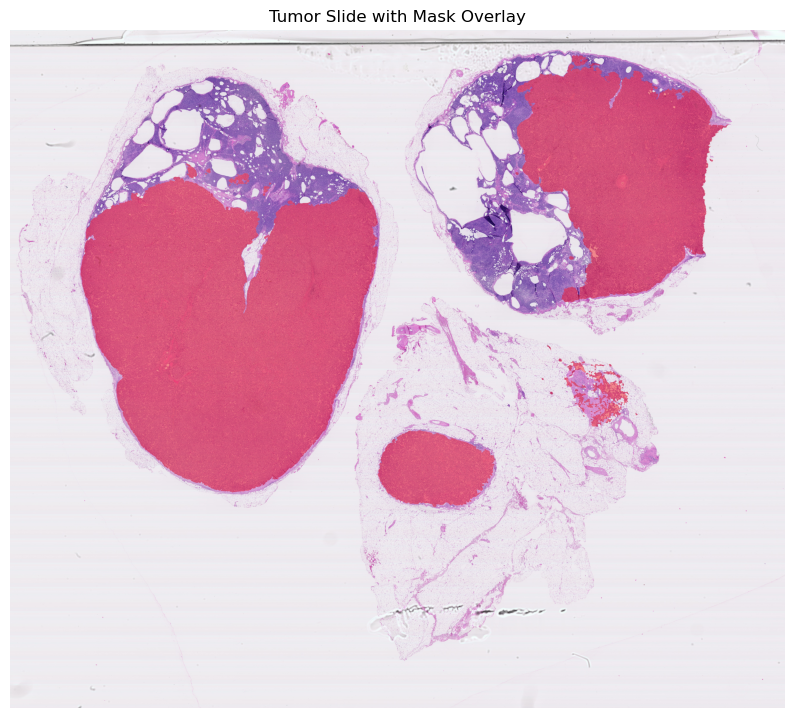

In [6]:
show_overlay(
    wsi_path=tumor_path,
    mask_path="tumor_076_mask.png",
    level=4,
    alpha=0.4
)


Processing slide: tumor_076
WSI path: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\img\tumor_076.tif
XML path: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\mask\annotations\tumor_076.xml
Thumbnail Level: 6, Dimensions: (1792, 1568), Downsample: 64.0
Thumbnail size: (1792, 1568)
Mask size: (1792, 1568)


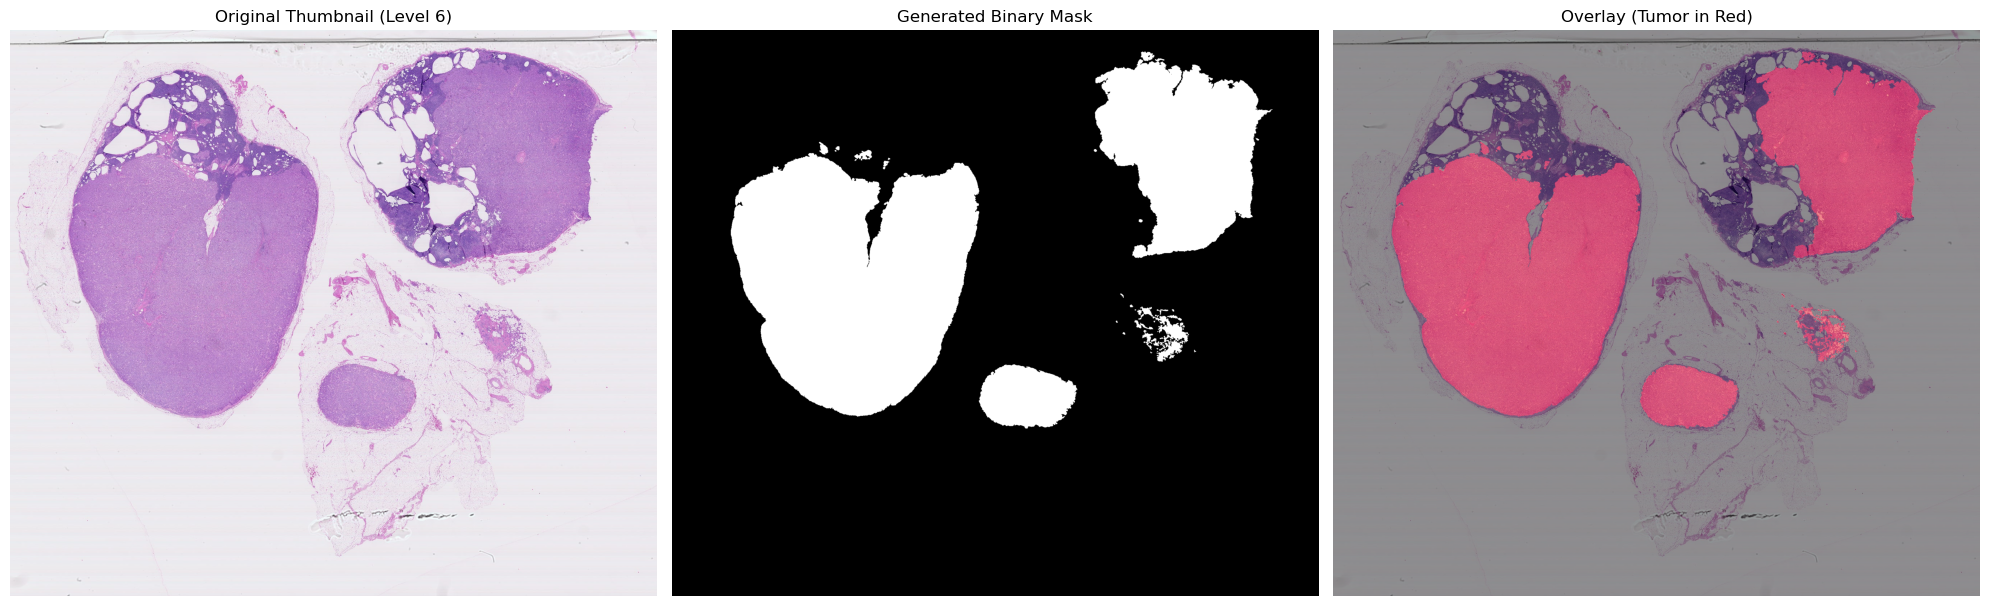

Visualization complete.


In [7]:
visualize_mask_and_thumbnail(slide_id="tumor_076", level=6)

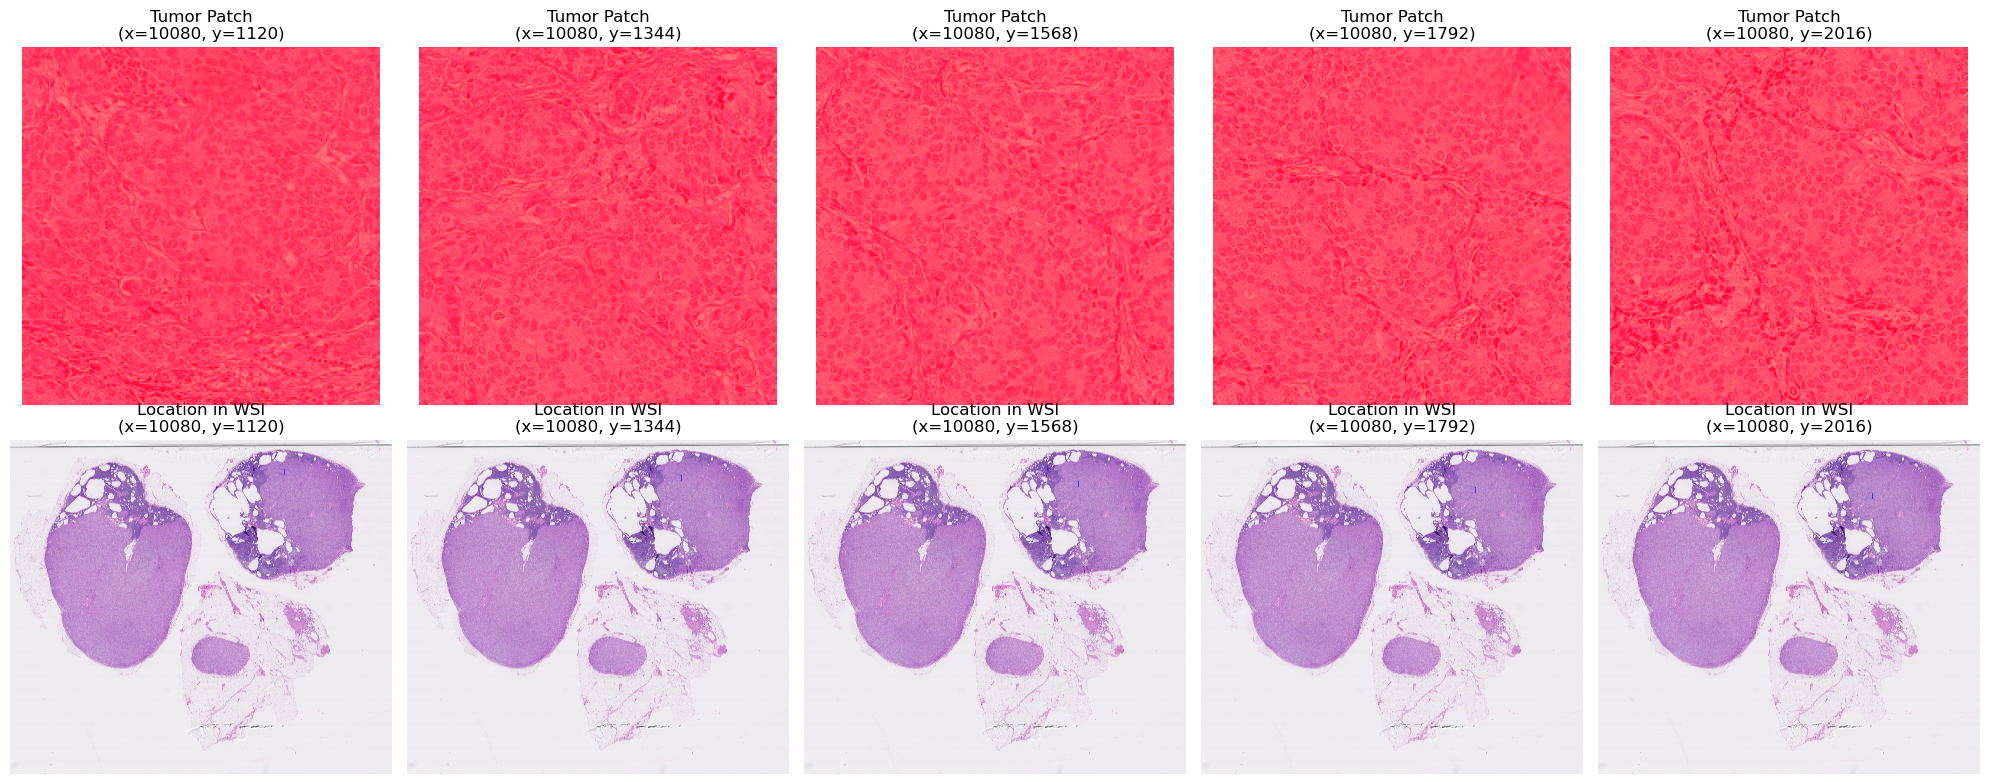

In [11]:
import glob

def visualize_tumor_patches(level=3, num_samples=5):
    # Directory containing patches
    patch_dir = os.path.join(
        os.getcwd(), "..", "data", "camelyon16", "patches", f"level_{level}", "tumor_076"
    )
    if not os.path.exists(patch_dir):
        print(f"{bcolors.ERROR}[ERROR]{bcolors.ENDC} Patch directory not found: {patch_dir}")
        return

    # Find tumor patches
    tumor_patches = sorted(glob.glob(os.path.join(patch_dir, "*_tumor.png")))
    normal_patches = sorted(glob.glob(os.path.join(patch_dir, "*_normal.png")))

    if not tumor_patches:
        print(f"{bcolors.WARNING}[WARNING]{bcolors.ENDC} No tumor patches found.")
        return

    # Sample patches
    tumor_samples = tumor_patches[:num_samples]
    normal_samples = normal_patches[:num_samples]

    # Open WSI and mask
    slide = OpenSlide(tumor_path)
    level_downsample = slide.level_downsamples[level]
    wsi_dims = slide.level_dimensions[level]

    # Try to load mask (generated previously)
    mask_path = os.path.join(
        os.getcwd(), "..", "data", "camelyon16", "train", "mask", "annotations", "tumor_076.xml"
    )
    mask = parse_xml_mask(mask_path, wsi_dims, slide)

    def extract_coords(fname):
        # EX: tumor_076_x1234_y5678_tumor.png
        base = os.path.basename(fname)
        parts = base.split("_")
        x = int(parts[2][1:])
        y = int(parts[3][1:])
        return x, y

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    for i, patch_path in enumerate(tumor_samples):
        x, y = extract_coords(patch_path)
        patch = Image.open(patch_path)
        # Overlay mask on patch
        if mask is not None:
            mask_patch = mask.crop((x, y, x+224, y+224)).convert("L")
            mask_overlay = np.array(patch).copy()
            mask_arr = np.array(mask_patch)
            mask_overlay[mask_arr > 0, 0] = 255  # Red channel
            mask_overlay[mask_arr > 0, 1:] = mask_overlay[mask_arr > 0, 1:] * 0.5
            axes[0, i].imshow(mask_overlay)
        else:
            axes[0, i].imshow(patch)
        axes[0, i].set_title(f"Tumor Patch\n(x={x}, y={y})")
        axes[0, i].axis("off")

        # Show location on WSI
        wsi_thumb = slide.read_region((0, 0), level, wsi_dims).convert("RGB")
        draw = ImageDraw.Draw(wsi_thumb)
        draw.rectangle([x, y, x+224, y+224], outline="red", width=4)
        axes[1, i].imshow(wsi_thumb)
        axes[1, i].set_title(f"Location in WSI\n(x={x}, y={y})")
        axes[1, i].axis("off")


        # Show location on WSI
        wsi_thumb = slide.read_region((0, 0), level, wsi_dims).convert("RGB")
        draw = ImageDraw.Draw(wsi_thumb)
        draw.rectangle([x, y, x+224, y+224], outline="blue", width=4)
        axes[1, i].imshow(wsi_thumb)
        axes[1, i].set_title(f"Location in WSI\n(x={x}, y={y})")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_tumor_patches(level=3, num_samples=5)